In [1]:
using Pkg
Pkg.activate("../")
Pkg.status()

  Activating environment at `~/WORK/HPL/Code/ina-julia/Project.toml`


      Status `~/WORK/HPL/Code/ina-julia/Project.toml`
  [6e4b80f9] BenchmarkTools v1.1.4
  [a134a8b2] BlackBoxOptim v0.6.0
  [336ed68f] CSV v0.9.0
  [a93c6f00] DataFrames v1.2.2
  [0c46a032] DifferentialEquations v6.18.0
  [587475ba] Flux v0.12.6
  [a75be94c] GalacticOptim v2.0.3
  [7073ff75] IJulia v1.23.2
  [429524aa] Optim v1.4.1
  [91a5bcdd] Plots v1.21.3
  [c3572dad] Sundials v4.5.3


# Load packages

In [2]:
using DifferentialEquations
using Sundials
using DataFrames: DataFrame
using CSV: File as CSVFile

using Plots
using BenchmarkTools

using Parameters
using Setfield

┌ Warning: Replacing module `NLsolve`
└ @ Base loading.jl:959


# Load CSV

In [3]:
dirname_data = "../data"
dirname_legends = joinpath(dirname_data, "legends")
dirname_protocols = joinpath(dirname_data, "protocols")

filename_legend_constants = joinpath(dirname_legends, "legend_constants_v2.csv")
filename_legend_states = joinpath(dirname_legends, "legend_states.csv")
filename_protocol = joinpath(dirname_protocols, "protocol_sparse.csv");

In [4]:
read_csv(filename) = DataFrame(CSVFile(filename))

read_csv (generic function with 1 method)

In [5]:
legend_states = read_csv(filename_legend_states)
legend_constants = read_csv(filename_legend_constants)
protocol = read_csv(filename_protocol);

In [6]:
find_step(t, protocol) = protocol.v[findfirst(x -> x >= t, protocol.t)]

function create_p_from_legend(legend)
    name = Symbol.(legend_constants.name)
    value = legend_constants.value
    p = (; zip(name, value)...)
end

create_p_from_legend (generic function with 1 method)

# Load equations

In [7]:
include("../src/models/ina.jl");
include("../src/models/currents.jl");

# Define model

In [8]:
function compute_algebraic(du, u, p, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
        
    tau_m  = calculate_tau_m(v_m, p)
    tau_h  = calculate_tau_h(v_m, p)
    tau_j  = calculate_tau_j(v_m, p)
    
    m_inf  = calculate_m_inf(v_m, p)
    h_inf  = calculate_h_inf(v_m, p)
    
    v_cp   = calculate_v_cp(v_comp, p)

    I_leak = 0 # calculate_I_leak(v_m, p)
    I_Na   = calculate_I_Na(v_m, m, h, j, p)
    I_c    = 0 # calculate_I_c(v_m, v_cp, I_leak, I_Na,  p)  # or calculate_I_c(v_m, v_p, I_leak, I_Na,  p)
    I_p    = 0  # or calculate_I_p(v_cp, v_p, p)
    I_comp = 0 # calculate_I_comp(v_comp, p)
    
    I_in   = I_leak + I_Na + I_c - I_comp + I_p
    
    a = (;
     tau_m, tau_h, tau_j, m_inf, h_inf,
     v_cp,
     I_leak, I_Na, I_c, I_comp, I_in
    )
    
end

compute_algebraic (generic function with 1 method)

In [9]:
function compute_rates!(du, u, p, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
    
    a = compute_algebraic(du, u, p, t)
    
    du[1] = calculate_d_v_comp(v_comp, p)  # v_comp
    
    @unpack v_cp, I_leak, I_Na = a
    du[2] = calculate_d_v_p(v_cp, v_p, p)  # v_p
    du[3] = calculate_d_v_m(v_m, v_p, I_leak, I_Na, p)  # v_m
        
    @unpack m_inf, tau_m, h_inf, tau_h, tau_j = a
    du[4] = calculate_d_gate(m_inf, m, tau_m)  # m
    du[5] = calculate_d_gate(h_inf, h, tau_h)  # h
    du[6] = calculate_d_gate(h_inf, j, tau_j)  # j
        
    @unpack I_in = a
    du[7] = calculate_d_I_out(I_in, I_out, p)  # I_out
    
    nothing
end

compute_rates! (generic function with 1 method)

In [10]:
rhs = ODEFunction(compute_rates!, syms=[:v_comp, :v_p, :v_m, :m, :h, :j, :I_out]);

# Callbacks

In [11]:
function change_step_v1!(integrator)
    t = integrator.t
    v_c = find_step(t, protocol)
    integrator.p["v_c"] = v_c
    set_proposed_dt!(integrator, 1e-9)
    nothing
end

cb_step_v1  = PresetTimeCallback(protocol.t, change_step_v1!, save_positions=(false, false));

# Globals

In [12]:
u₀ = [-80.0, -80.0, -80.0, 0.0, 1.0, 1.0, 0.0];
reltol = 1e-3
abstol = [1e-3, 1e-3, 1e-3, 1e-6, 1e-6, 1e-6, 1e-3]
solver = Rodas4();
tspan_initial = (0., 10.)
tspan = (0., 5.)
saveat = tspan[1]: 5e-5: tspan[2]

0.0:5.0e-5:5.0

# Loss

In [13]:
legend_constants

30×5 DataFrame
 Row │ name       value            bound_1       bound_2       is_log 
     │ InlineSt…  Float64          Float64       Float64       Int64  
─────┼────────────────────────────────────────────────────────────────
   1 │ c_p            4.50296e-12       1.0e-14       5.0e-12       1
   2 │ c_m            2.47302e-11       1.0e-11       9.0e-11       1
   3 │ a0_m       16529.1           10000.0      100000.0           1
   4 │ b0_m         386.7             100.0        1000.0           1
   5 │ delta_m       22.823             1.0         100.0           1
   6 │ s_m           12.8321            1.0         100.0           1
   7 │ a0_h           6.26              1.0         100.0           1
   8 │ b0_h       58131.4           10000.0      100000.0           1
   9 │ delta_h       10.2758            1.0         100.0           1
  10 │ s_h           21.62              1.0         100.0           1
  11 │ a0_j           0.6462            0.01          1.0           1
  ⋮  │     ⋮             ⋮              ⋮             ⋮          ⋮
  21 │ v_half_m      28.358            10.0          60.0           1
  22 │ v_half_h      59.6912           50.0         100.0           1
  23 │ k_m            7.66677           1.0          10.0           1
  24 │ k_h            5.50777           1.0          10.0           1
  25 │ x_c_comp       0.01              0.01          0.999         1
  26 │ x_r_comp       0.2               0.01          0.999         1
  27 │ alpha          0.75              0.7           0.8           1
  28 │ v_off         -2.0             -15.0          15.0           0
  29 │ v_rev         18.0             -50.0          50.0           0
  30 │ v_c          -80.0            -100.0         100.0           0
                                                        9 rows omitted

In [14]:
p_dict = Dict(zip(legend_constants.name, legend_constants.value));

In [15]:
p_keys_opt_m = ["a0_m", "s_m", "b0_m", "delta_m", "v_half_m", "k_m"]
p_keys_opt_h = ["a0_h", "s_h", "b0_h", "delta_h", "v_half_h", "k_h"]
p_keys_opt_j = ["tau_j_const", "a0_j", "s_j", "b0_j", "delta_j"]

p_keys_opt_INa = ["g_max", "v_rev"]

p_keys_opt = vcat(p_keys_opt_m, p_keys_opt_h, p_keys_opt_j)

17-element Vector{String}:
 "a0_m"
 "s_m"
 "b0_m"
 "delta_m"
 "v_half_m"
 "k_m"
 "a0_h"
 "s_h"
 "b0_h"
 "delta_h"
 "v_half_h"
 "k_h"
 "tau_j_const"
 "a0_j"
 "s_j"
 "b0_j"
 "delta_j"

In [16]:
legend_subset = legend_constants[in(p_keys_opt).(legend_constants.name), :]

17×5 DataFrame
 Row │ name         value        bound_1     bound_2     is_log 
     │ InlineSt…    Float64      Float64     Float64     Int64  
─────┼──────────────────────────────────────────────────────────
   1 │ a0_m         16529.1      10000.0     100000.0         1
   2 │ b0_m           386.7        100.0       1000.0         1
   3 │ delta_m         22.823        1.0        100.0         1
   4 │ s_m             12.8321       1.0        100.0         1
   5 │ a0_h             6.26         1.0        100.0         1
   6 │ b0_h         58131.4      10000.0     100000.0         1
   7 │ delta_h         10.2758       1.0        100.0         1
   8 │ s_h             21.62         1.0        100.0         1
   9 │ a0_j             0.6462       0.01         1.0         1
  10 │ b0_j         11358.3       1000.0     100000.0         1
  11 │ delta_j          7.445        1.0        100.0         1
  12 │ s_j             69.417        1.0        100.0         1
  13 │ tau_j_const      0.00132      0.0001       0.005       1
  14 │ v_half_m        28.358       10.0         60.0         1
  15 │ v_half_h        59.6912      50.0        100.0         1
  16 │ k_m              7.66677      1.0         10.0         1
  17 │ k_h              5.50777      1.0         10.0         1

In [17]:
mask_log = Dict(zip(legend_constants.name,
                    Array{Bool}(legend_constants.is_log)));

In [18]:
function prepare_p(x::Vector{Float64})
    
    @assert length(x) == length(p_keys_opt)
    
    p = deepcopy(p_dict)
    for (k, v, is_log) in zip(p_keys_opt, x, mask_log)
        p[k] = mask_log[k] ? exp(v) : v
#         p[k] = v

    end
    
    return p
    
end

prepare_p (generic function with 1 method)

In [19]:
function solve_model(p)
    
    # print(p)
    prob = ODEProblem(rhs, u₀, tspan, p, callback=cb_step_v1)
    solve_kwargs = (; reltol, abstol, solver, saveat)
    sol = solve(prob; solve_kwargs...)
    # println("full")

    return sol
end

solve_model (generic function with 1 method)

In [20]:
function calculate_rmse(x, y)
    se = (x .- y) .^2
    return √mean(se)
end

calculate_rmse (generic function with 1 method)

In [21]:
function calculate_loss(x)
    
    p = prepare_p(x)
    sol = solve_model(p)
    
    if sol.retcode ≠ :Success
        loss = Inf
    else
        loss = calculate_rmse(sol[:I_out], data)
    end
    
    # println(loss)
        
    return loss
    
end

calculate_loss (generic function with 1 method)

# Generate data

In [22]:
x₀ = [mask_log[k] ? log.(p_dict[k]) : p_dict[k] for k in p_keys_opt]

17-element Vector{Float64}:
  9.71287532289443
  2.55194984411125
  5.957649198613251
  3.12776879942174
  3.344909882583472
  2.0368954054310784
  1.8341801851120072
  3.073618812211062
 10.970461364771992
  2.3297945357086913
  4.089184103261701
  1.706160004112492
 -6.630123542383857
 -0.43664622559173916
  4.240131794288081
  9.337704913602511
  2.0075426661359725

In [23]:
p = prepare_p(x₀);

In [24]:
sol = solve_model(p);

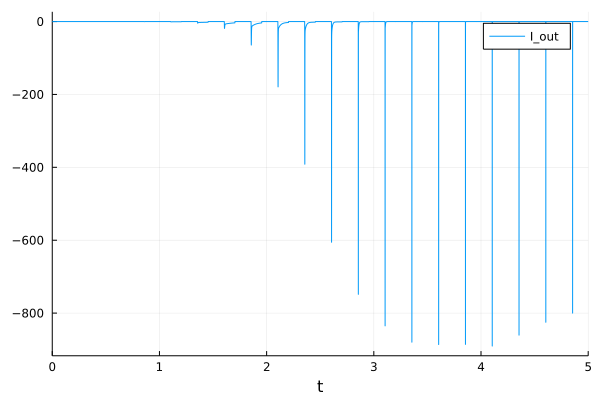

In [25]:
plot(sol, vars=[:I_out])

In [26]:
data = copy(sol[:I_out]);

In [27]:
calculate_rmse(sol[:I_out], data)

0.0

In [28]:
calculate_loss(x₀)

0.0

# Optimize

In [29]:
using BlackBoxOptim

In [30]:
using PyCall
so = pyimport("scipy.optimize");

In [31]:
bounds = [minmax(x - 1, x + 1) for x in x₀]

17-element Vector{Tuple{Float64, Float64}}:
 (8.71287532289443, 10.71287532289443)
 (1.5519498441112498, 3.55194984411125)
 (4.957649198613251, 6.957649198613251)
 (2.12776879942174, 4.12776879942174)
 (2.344909882583472, 4.344909882583472)
 (1.0368954054310784, 3.0368954054310784)
 (0.8341801851120072, 2.8341801851120074)
 (2.073618812211062, 4.073618812211063)
 (9.970461364771992, 11.970461364771992)
 (1.3297945357086913, 3.3297945357086913)
 (3.089184103261701, 5.089184103261701)
 (0.706160004112492, 2.7061600041124922)
 (-7.630123542383857, -5.630123542383857)
 (-1.4366462255917392, 0.5633537744082608)
 (3.2401317942880814, 5.240131794288081)
 (8.337704913602511, 10.337704913602511)
 (1.0075426661359725, 3.0075426661359725)

In [32]:
lb = [b[1] for b in bounds]
ub = [b[2] for b in bounds];

In [33]:
x_initial = [b[1] + rand() * (b[2] - b[1]) for b in bounds];

In [ ]:
res = bboptimize(calculate_loss; SearchRange=bounds, MaxTime=10 * 60., TraceInterval=30,
                 PopulationSize=100,
                 );

In [35]:
x_bbo = best_candidate(res);

In [44]:
res = so.minimize((x, args) -> calculate_loss(x), x_bbo, bounds, method="Nelder-Mead", options=Dict(:maxiter => 1000))

Dict{Any, Any} with 8 entries:
  "fun"           => 1.12433
  "nit"           => 1000
  "nfev"          => 1323
  "status"        => 2
  "success"       => false
  "message"       => "Maximum number of iterations has been exceeded."
  "x"             => [9.75438, 2.70716, 5.86755, 3.41237, 3.34671, 2.18275, 1.8…
  "final_simplex" => ([9.75438 2.70716 … 6.47718 2.52857; 9.71733 2.71372 … 6.4…

In [80]:
x_best = res["x"]

17-element Vector{Float64}:
  9.764207602632787
  2.63800597888695
  6.06950397285156
  3.8503202807367956
  3.45346959719517
  2.152770274203296
  3.705166703025613
  3.123712848270899
 10.90452263847278
  2.308550238678057
  4.30357076811989
  1.9840310184655272
 -9.199882602361818
  0.5763303893812786
  4.95670258981578
  8.405805072598426
  2.1373290410385763

In [75]:
res = so.minimize((x, args) -> calculate_loss(x), x_best, bounds, method="Nelder-Mead", options=Dict(:maxiter => 1000))

Dict{Any, Any} with 8 entries:
  "fun"           => 0.368018
  "nit"           => 1000
  "nfev"          => 1387
  "status"        => 2
  "success"       => false
  "message"       => "Maximum number of iterations has been exceeded."
  "x"             => [9.76421, 2.63801, 6.0695, 3.85032, 3.45347, 2.15277, 3.70…
  "final_simplex" => ([9.76421 2.63801 … 8.40581 2.13733; 9.76306 2.63825 … 8.4…

In [81]:
df = DataFrame(Name = p_keys_opt,
          True = x₀,
          Lb = lb,
          Best = x_best,
          Ub = ub);
df[:, 2:end] = exp.(df[:, 2:end]);
df.relerr = (df.Best - df.True) ./ df.Best * 100.;

In [82]:
df

17×6 DataFrame
 Row │ Name         True         Lb               Best             Ub          ⋯
     │ String       Float64      Float64          Float64          Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ a0_m         16529.1       6080.7          17399.7          44930.6     ⋯
   2 │ s_m             12.8321       4.72067         13.9853          34.8813
   3 │ b0_m           386.7        142.259          432.466         1051.16
   4 │ delta_m         22.823        8.39611         47.0081          62.0393
   5 │ v_half_m        28.358       10.4323          31.6099          77.0851  ⋯
   6 │ k_m              7.66677      2.82045          8.60867         20.8404
   7 │ a0_h             6.26         2.30293         40.6568          17.0164
   8 │ s_h             21.62         7.95355         22.7306          58.7693
   9 │ b0_h         58131.4      21385.3          54421.9              1.58018 ⋯
  10 │ delta_h         10.2758       3.78027         10.0598          27.9326
  11 │ v_half_h        59.6912      21.9592          73.9634         162.257
  12 │ k_h              5.50777      2.0262           7.272           14.9717
  13 │ tau_j_const      0.00132      0.000485601      0.000101051      0.00358 ⋯
  14 │ a0_j             0.6462       0.237724         1.7795           1.75655
  15 │ s_j             69.417       25.5371         142.124          188.695
  16 │ b0_j         11358.3       4178.49          4472.96         30875.1
  17 │ delta_j          7.445        2.73886          8.47677         20.2376  ⋯
                                                               2 columns omitted

In [83]:
calculate_loss(x_bbo), calculate_loss(x_best)

(7.944202834960928, 0.36801813738539113)

In [84]:
p_best = prepare_p(x_best)
sol_best = solve_model(p_best);

In [85]:
plot(sol_best, vars=[:I_out])
plot!(sol_best.t, data)
plot!(ylims=(-10, 10))

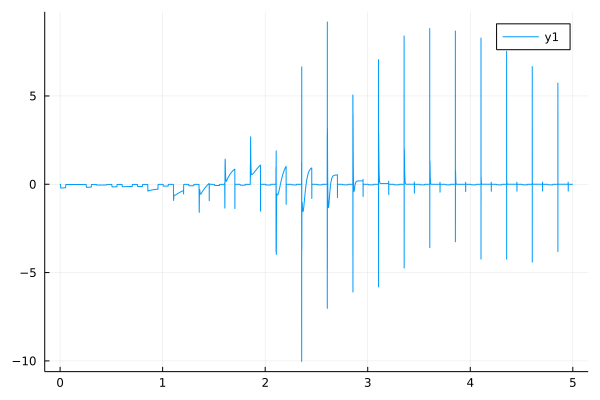

In [86]:
plot(sol_best.t, sol_best[:I_out] - data)